In [94]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier

# Load the dataset# Load the dataset
file_path = "../dags/data/RTA_Dataset.csv"
df = pd.read_csv(file_path) 

In [95]:
# Drop all rows with missing values
df = df.dropna()

In [96]:
# Select relevant columns
columns = [
    'day_of_week', 'age_band_of_driver', 'type_of_vehicle',
    'area_accident_occured', 'lanes_or_medians',
    'types_of_junction', 'weather_conditions', 'accident_severity'
]
# Convert all column names to lowercase
df.columns = df.columns.str.lower()
df = df[columns].copy()

In [97]:
# 1. Clean 'day_of_week'
valid_days = ['monday', 'sunday', 'friday', 'wednesday', 'saturday', 'thursday', 'tuesday']
df['day_of_week'] = df['day_of_week'].str.lower()
df = df[df['day_of_week'].isin(valid_days)]

In [98]:
# 2. Clean 'age_band_of_driver'
df = df[df['age_band_of_driver'] != 'Under 18']
df['age_band_of_driver'] = df['age_band_of_driver'].replace({
    'Over 51': '>51',
    'Unknown': 'unknown'
})

In [99]:
# 3. Simplify 'type_of_vehicle'
car_types = ['Automobile', 'Taxi', 'Stationwagen']
lorry_types = ['Lorry (41?100Q)', 'Lorry (11?40Q)', 'Long lorry', 'Pick up upto 10Q']
bus_types = ['Public (> 45 seats)', 'Public (12 seats)', 'Public (13?45 seats)']
motorcycle_types = ['Motorcycle', 'Bajaj', 'Motorcycle (below 400cc)']
other_types =['Ridden horse','Other','Special vehicle','Turbo','Bicycle']

def simplify_vehicle_type(v):
    if v in car_types:
        return 'car'
    elif v in lorry_types:
        return 'lorry'
    elif v in bus_types:
        return 'bus'
    elif v in motorcycle_types:
        return 'motorcycle'
    elif v in other_types:
        return 'other'
    else:
        return 'other'
df['type_of_vehicle'] = df['type_of_vehicle'].apply(simplify_vehicle_type)

In [100]:
# transform categorical features
types_of_junction_to_types_of_junction = {
    "Y Shape":"y_shape",
    "No junction":"no_junction",
    "Crossing":  "crossing",
    "Other":  "other",
    "Unknown":  "unknown",
    "O Shape":"o_shape",
    "T Shape":"t_shape",
    "X Shape":"x_shape",
}
df["types_of_junction"] = df["types_of_junction"].map(types_of_junction_to_types_of_junction)

In [101]:
# transform 'area_accident_occured'
area_to_highway = {
    "Other": "road",
    "Office areas": "service",
    "Residential areas": "residential",
    "Church areas": "service",
    "Industrial areas": "service",
    "School areas": "living_street",
    "Recreational areas": "living_street",
    "Outside rural areas": "unclassified",
    "Hospital areas": "service",
    "Market areas": "living_street",
    "Rural village areas": "tertiary",
    "Unknown": "road",
    "Rural village areasOffice areas": "road",  # Inconsistent value
    # Possible trimmed version to cover any leading/trailing whitespace
    "  Recreational areas": "living_street",
    "  Market areas": "living_street"
}
df["area_accident_occured"] = df["area_accident_occured"].dropna()
df["area_accident_occured"] = df["area_accident_occured"].map(area_to_highway)

In [102]:
# transform 'lanes_or_medians'
df["lanes_or_medians"] = df["lanes_or_medians"].apply(
    lambda x: "two_way" if 'two way' in x.lower() or 'two-way' in x.lower()
    else "one_way" if 'double carriageway' in x.lower()
    else x.strip().replace(" ", "_").lower() 
)

In [103]:
# transform 'weather_conditions'
df["weather_conditions"] = df["weather_conditions"].apply(
    lambda x: "rain" if "rain" in x.lower() else "no_rain"
)

In [104]:
# transfrom 'accident_severity' # target
df['accident_severity'] = df['accident_severity'].str.lower()
df['accident_severity'] = df['accident_severity'].map(lambda x: x.split(' ')[0] if ' ' in x else x)


In [105]:
df.describe(include='all')
df.info()
for col in columns:
    print(df[col].unique())  # Check unique values before encoding

<class 'pandas.core.frame.DataFrame'>
Index: 2689 entries, 8 to 12315
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   day_of_week            2689 non-null   object
 1   age_band_of_driver     2689 non-null   object
 2   type_of_vehicle        2689 non-null   object
 3   area_accident_occured  2195 non-null   object
 4   lanes_or_medians       2689 non-null   object
 5   types_of_junction      2689 non-null   object
 6   weather_conditions     2689 non-null   object
 7   accident_severity      2689 non-null   object
dtypes: object(8)
memory usage: 189.1+ KB
['friday' 'thursday' 'tuesday' 'wednesday' 'saturday' 'sunday' 'monday']
['18-30' '31-50' '>51' 'unknown']
['lorry' 'car' 'bus' 'other' 'motorcycle']
[nan 'residential' 'service' 'living_street' 'tertiary' 'road']
['other' 'two_way' 'one_way' 'unknown']
['y_shape' 'no_junction' 'crossing' 'o_shape' 'other' 'unknown' 't_shape'
 'x_shape']
['no_r

In [106]:
categorical_cols = df.select_dtypes(include="object").columns  
# Encode features and target
df['accident_severity'] = df['accident_severity'].map({
    'slight': 0, 'serious': 1, 'fatal': 2
})
# One-hot encode categorical features
filtered_cols = [col for col in categorical_cols if col not in ['accident_severity']]
df_encoded = pd.get_dummies(df[filtered_cols]) 
# Ensure all features are numeric (convert bools to ints)
df_encoded = df_encoded.astype(int)

# Define features and target
X = df_encoded
y = df['accident_severity']

print(X.shape)
print(y.shape)
print(y.isna().sum())

# label_encoders = {}
# for col in X.columns:
#     le = LabelEncoder()
#     X[col] = le.fit_transform(X[col])
#     label_encoders[col] = le

# le_target = LabelEncoder()
# y = le_target.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train model
model = RandomForestClassifier(random_state=42)
model.fit(X_resampled, y_resampled)
# Initialize Balanced Random Forest
brf_model = BalancedRandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
brf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = brf_model.predict(X_test)

# Evaluate
y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

(2689, 35)
(2689,)
0
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.86      0.87       472
           1       0.12      0.15      0.13        62
           2       0.00      0.00      0.00         4

    accuracy                           0.77       538
   macro avg       0.33      0.33      0.33       538
weighted avg       0.79      0.77      0.78       538



types_of_junction_y_shape              0.051678
type_of_vehicle_car                    0.050841
area_accident_occured_road             0.049656
age_band_of_driver_18-30               0.048780
type_of_vehicle_lorry                  0.048058
age_band_of_driver_31-50               0.046081
day_of_week_friday                     0.044358
types_of_junction_no_junction          0.043352
lanes_or_medians_two_way               0.041788
types_of_junction_crossing             0.040095
day_of_week_thursday                   0.040083
day_of_week_saturday                   0.039614
area_accident_occured_service          0.038740
day_of_week_tuesday                    0.038351
age_band_of_driver_unknown             0.034884
type_of_vehicle_bus                    0.033133
day_of_week_monday                     0.031603
day_of_week_wednesday                  0.031346
area_accident_occured_residential      0.030512
day_of_week_sunday                     0.029180
age_band_of_driver_>51                 0

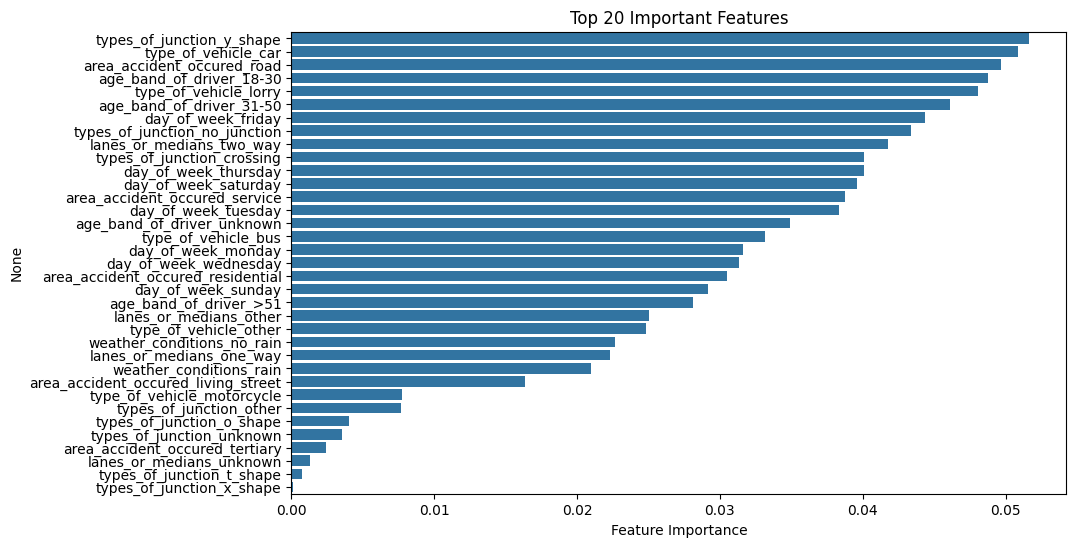

In [108]:
# Feature importance in influencing accident severity

from matplotlib import pyplot as plt
import seaborn as sns
importances = pd.Series(model.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(20)

importances = pd.Series(model.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False)
print(top_features)

top_features_df = pd.DataFrame({'Feature': top_features.index, 'Importance': top_features.values})
csv_filename = '../dags/data/top_feature_importances.csv'
top_features_df.to_csv(csv_filename, index=False)
print(f"Top feature importances saved to '{csv_filename}' in the same directory as this notebook.")

plt.figure(figsize=(10,6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Top 20 Important Features")
plt.xlabel("Feature Importance")
plt.show()


In [112]:
import joblib

# Save the trained model
joblib.dump(model, 'accident_severity_model.pkl')

# # Save the label encoder for target (to decode predictions later)
# joblib.dump(le_target, 'label_encoder_target.pkl')

# # Optionally, save all feature label encoders
# joblib.dump(label_encoders, 'feature_label_encoders.pkl')


['accident_severity_model.pkl']

In [114]:
# Load model and encoders
model = joblib.load('accident_severity_model.pkl')
# le_target = joblib.load('label_encoder_target.pkl')
# label_encoders = joblib.load('feature_label_encoders.pkl')

# Example of how to use the model for prediction
def predict_accident_severity(new_data):
    # Transform new data using the saved label encoders
    # for col, le in label_encoders.items():
    #     new_data[col] = le.transform(new_data[col])
    
    # Predict using the model
    prediction = model.predict(new_data)
    
    # Decode the prediction using the target label encoder
    # decoded_prediction = le_target.inverse_transform(prediction)
    
    return prediction



# Example usage of the predict function
new_data = pd.DataFrame({
    'day_of_week': ['friday'],
    'age_band_of_driver': ['18-30'],
    'type_of_vehicle': ['car'],
    'area_accident_occured': ['road'],
    'lanes_or_medians': ['two_way'],
    'types_of_junction': ['y_shape'],
    'weather_conditions': ['rain']
})
new_data = new_data.reindex(columns=X.columns, fill_value=0)  # Ensure the same columns as training data
predicted_severity = predict_accident_severity(new_data)
print(predicted_severity)

[2]
